In [ ]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import glob
import seaborn as sns
from keras.models import Sequential
from keras.layers import ConvLSTM2D, BatchNormalization, Dense
from keras.utils import to_categorical
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score, roc_curve, auc
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model
from IPython.display import Image

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
def convert_2d(df_dup):
    data_frame = pd.DataFrame()
    for i in range(0, df_dup.shape[0]-59):
        is_anomaly = False
        mylist = []
        for j in range(i, i+60):
            mylist.append(df_dup['value'].iat[j])
            if df_dup['is_anomaly'].iat[j] == 1:
                is_anomaly = True
        if is_anomaly:
            mylist.append(1)
        else:
            mylist.append(0)
        np_Array = np.array(mylist)
        mylist = np_Array.T
        data_frame = data_frame.append(pd.Series(mylist), ignore_index=True)
    return data_frame

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/ydata-labeled-time-series-anomalies-v1_0/A1Benchmark/real_1.csv")


In [ ]:
path = r'/content/drive/MyDrive/ydata-labeled-time-series-anomalies-v1_0/A1Benchmark'
all_files = glob.glob(path + "/*.csv")

In [ ]:
dataset_conc = []
for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    df = df.replace(0, np.nan)
    df = df.dropna(axis=0, how='any', subset=['value'])
    df.value = preprocessing.normalize([df.value]).T
    dataset_conc.append(convert_2d(df))

frame = pd.concat(dataset_conc, axis=0, ignore_index=True)

Streaming output truncated to the last 5000 lines.
<ipython-input-24-e9b63d8afbd4>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_frame = data_frame.append(pd.Series(mylist), ignore_index=True)
<ipython-input-24-e9b63d8afbd4>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_frame = data_frame.append(pd.Series(mylist), ignore_index=True)
<ipython-input-24-e9b63d8afbd4>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_frame = data_frame.append(pd.Series(mylist), ignore_index=True)
<ipython-input-24-e9b63d8afbd4>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_frame = data_frame.append(pd.Series(mylist), ignore_i

In [ ]:
print(frame.columns)

RangeIndex(start=0, stop=61, step=1)


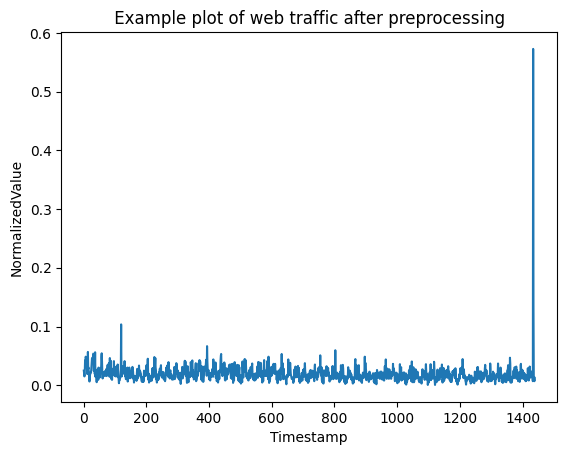

In [ ]:
import matplotlib.pyplot as plt
plt.plot(df.timestamp,df.value)
plt.xlabel("Timestamp")
plt.ylabel("NormalizedValue")
plt.title(" Example plot of web traffic after preprocessing ")
plt.show()

In [ ]:
from keras.models import Sequential
from keras.layers import Dense,Reshape,Conv2D,Flatten,MaxPooling1D,Conv1D,LSTM
from keras import optimizers
model=Sequential()
model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='tanh',input_shape=(60, 1)))
model.add(MaxPooling1D(pool_size=2, strides=2))
model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='tanh'))
model.add(MaxPooling1D(pool_size=2, strides=2))
model.add(Reshape((1,15*64)))
model.add(LSTM(64, activation='tanh',return_sequences='False'))
model.add(Flatten())
model.add(Dense(32, activation='tanh'))
model.add(Dense(2, activation='softmax'))
model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])
model.summary()


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 60, 64)            384       
                                                                 
 max_pooling1d (MaxPooling1  (None, 30, 64)            0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 30, 64)            20544     
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 15, 64)            0         
 g1D)                                                            
                                                                 
 reshape (Reshape)           (None, 1, 960)            0         
                                                                 
 lstm (LSTM)                 (None, 1, 64)            

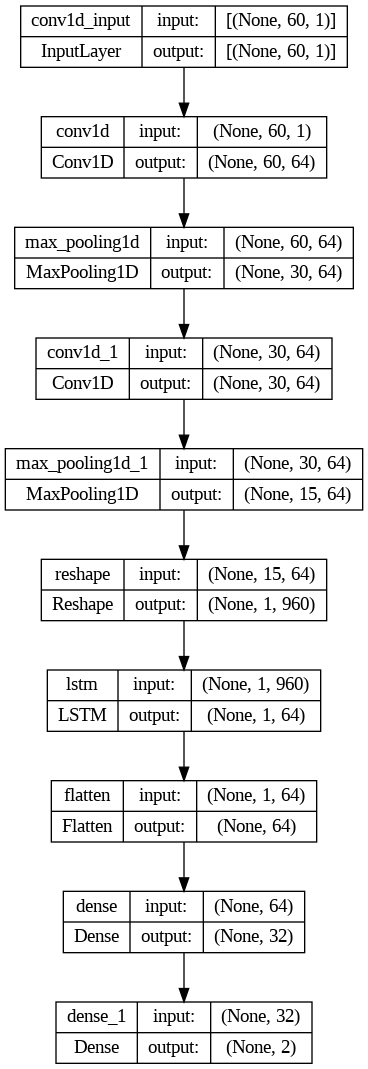

In [ ]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
y = frame.iloc[:, 60]
X = frame.iloc[:, 0:60]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [ ]:
smote = SMOTE(sampling_strategy='minority', random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)


In [ ]:
y_train_resampled = to_categorical(y_train_resampled, num_classes=2)
y_test = to_categorical(y_test, num_classes=2)

In [ ]:
class_weights_resampled = class_weight.compute_sample_weight(class_weight='balanced', y=y_train_resampled[:, 1])

In [ ]:
history = model.fit(x=X_train_resampled, y=y_train_resampled, batch_size=256, epochs=10, verbose=2,
                    sample_weight=class_weights_resampled,
                    validation_data=(X_test, y_test))

Epoch 1/10
440/440 - 5s - loss: 0.0686 - accuracy: 0.9739 - val_loss: 0.1147 - val_accuracy: 0.9720 - 5s/epoch - 11ms/step
Epoch 2/10
440/440 - 3s - loss: 0.0591 - accuracy: 0.9784 - val_loss: 0.1177 - val_accuracy: 0.9724 - 3s/epoch - 7ms/step
Epoch 3/10
440/440 - 2s - loss: 0.0605 - accuracy: 0.9780 - val_loss: 0.1414 - val_accuracy: 0.9637 - 2s/epoch - 5ms/step
Epoch 4/10
440/440 - 2s - loss: 0.0571 - accuracy: 0.9794 - val_loss: 0.1323 - val_accuracy: 0.9672 - 2s/epoch - 5ms/step
Epoch 5/10
440/440 - 3s - loss: 0.0546 - accuracy: 0.9800 - val_loss: 0.1037 - val_accuracy: 0.9746 - 3s/epoch - 7ms/step
Epoch 6/10
440/440 - 3s - loss: 0.0545 - accuracy: 0.9799 - val_loss: 0.1427 - val_accuracy: 0.9567 - 3s/epoch - 6ms/step
Epoch 7/10
440/440 - 2s - loss: 0.0538 - accuracy: 0.9805 - val_loss: 0.1530 - val_accuracy: 0.9553 - 2s/epoch - 5ms/step
Epoch 8/10
440/440 - 2s - loss: 0.0550 - accuracy: 0.9794 - val_loss: 0.1242 - val_accuracy: 0.9717 - 2s/epoch - 5ms/step
Epoch 9/10
440/440 - 2s

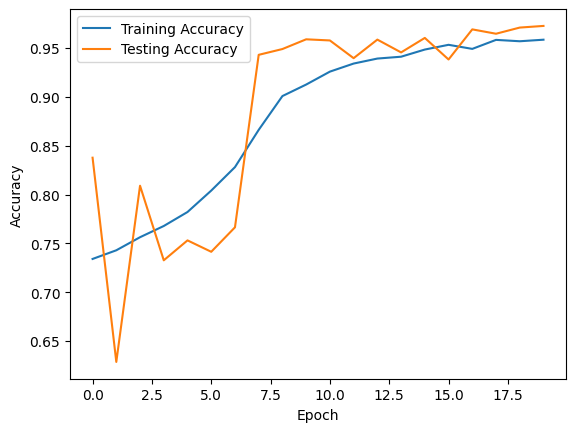

In [ ]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Testing Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

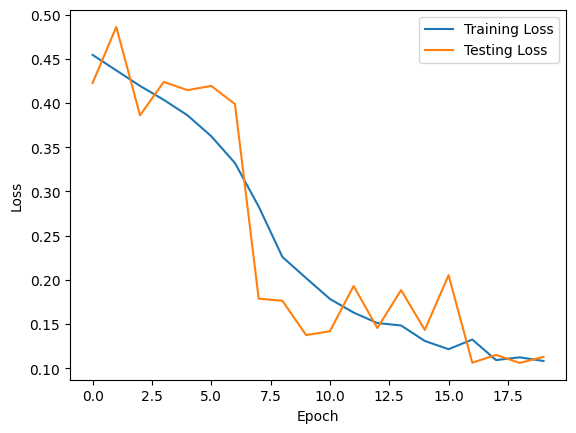

In [ ]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

832/832 [==============================] - 2s 2ms/step


In [ ]:
fpr, tpr, _ = roc_curve(y_test[:, 1], y_pred)
roc_auc = auc(fpr, tpr)

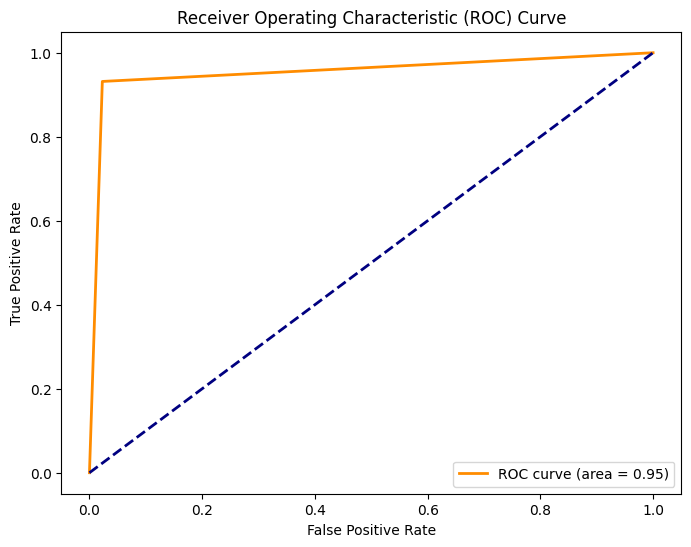

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

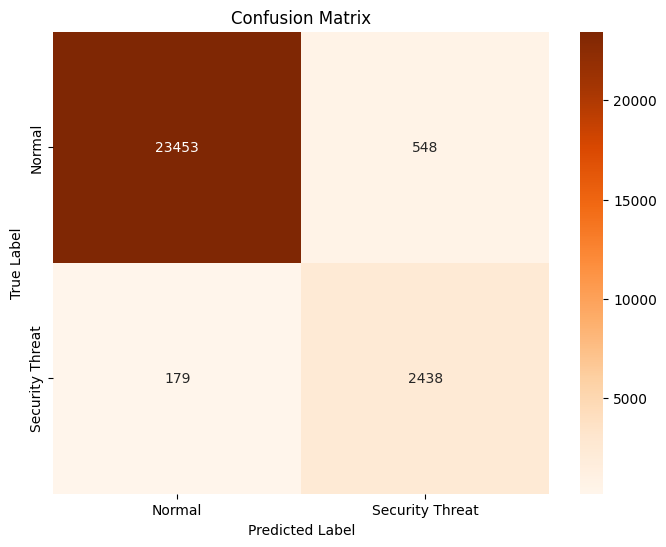

In [ ]:
confusion_matrix = confusion_matrix(y_test[:, 1], y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Oranges", xticklabels=['Normal', 'Security Threat'], yticklabels=['Normal', 'Security Threat'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
accuracy = accuracy_score(y_test[:, 1], y_pred)
precision = precision_score(y_test[:, 1], y_pred, average='binary')
recall = recall_score(y_test[:, 1], y_pred, average='binary')
f1_score = f1_score(y_test[:, 1], y_pred, average='binary')
sensitivity = recall
specificity = confusion_matrix[0, 0] / (confusion_matrix[0, 0] + confusion_matrix[0, 1])
false_positive_results = confusion_matrix[0, 1]
false_negative_results = confusion_matrix[1, 0]

print("Confusion Matrix")
print(confusion_matrix)
print("Accuracy ", accuracy)
print("Precision ", precision)
print("Recall ", recall)
print("F1 Score ", f1_score)
print("Specificity ", specificity)


Confusion Matrix
[[23453   548]
 [  179  2438]]
Accuracy  0.9726876549703208
Precision  0.8164768921634293
Recall  0.9316010699273978
F1 Score  0.8702480813849723
Specificity  0.977167618015916
